# Model Processing

## Imports & General Settings 

In [7]:
import unittest

from pycwt import Morlet
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange, tqdm
import sklearn
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_curve, roc_auc_score
from sklearn import metrics

# Our imports
from data import WaveletTransform, AFECGDataset, SecondDataset, WrapperDataset
import dsp
from model.blocks import ConvNet, BRNN, SoftmaxAttention
from model.baseline import Baseline
from training import train, test
import utils


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
testCase = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Dataset creation

In [3]:
dataset_name='afdb'
dataset = SecondDataset(dataset_name, '../data/files/', wt=WaveletTransform(Morlet(6), resample=20))
class_weights = dataset.load('./backup')

Loaded 2300 samples from backup
torch.Size([2300])
torch.Size([2300, 20, 375])


### Dataset balancing

The dataset is augmented to contain a balanced number of positive and negative examples

In [4]:
true_examples = dataset.samples[dataset.labels == 1]
false_examples = dataset.samples[dataset.labels == 0]
false_labels = dataset.labels[dataset.labels == 0]
augmented = []
augmented_labels = []
for i in range(len(false_examples) // len(true_examples)):
    augmented.append(true_examples.clone())
    augmented_labels.append(torch.ones(len(true_examples)).long())

dataset.samples = torch.cat([torch.cat(augmented), false_examples])
dataset.labels = torch.cat([torch.cat(augmented_labels), false_labels])

## Training

In [5]:
heldout = int(len(dataset) * 0.2)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - heldout, heldout])

# model = Baseline(add_brnn=True, hidden_size=100)
model = nn.Sequential(
    ConvNet(size=(375, 20), batch=False),
    nn.Linear(50, 2)
)

config = dict(
    num_workers=8,
    batch_size=90,
    learning_rate=0.0005,
    weight_decay=0.01,
    class_weights=None,
    num_epochs=20,
    is_notebook=True
)

train(model, train_dataset, config)


Epoch [1/20], Accuracy: 62.23%



Epoch [2/20], Accuracy: 72.36%



Epoch [3/20], Accuracy: 75.36%



Epoch [4/20], Accuracy: 77.01%



Epoch [5/20], Accuracy: 78.60%



Epoch [6/20], Accuracy: 77.94%



Epoch [7/20], Accuracy: 79.48%



Epoch [8/20], Accuracy: 80.80%



Epoch [9/20], Accuracy: 81.43%



Epoch [10/20], Accuracy: 82.20%



Epoch [11/20], Accuracy: 84.34%



Epoch [12/20], Accuracy: 85.22%



Epoch [13/20], Accuracy: 87.03%



Epoch [14/20], Accuracy: 88.05%



Epoch [15/20], Accuracy: 90.52%



Epoch [16/20], Accuracy: 90.71%



Epoch [17/20], Accuracy: 90.41%



Epoch [18/20], Accuracy: 92.01%



Epoch [19/20], Accuracy: 93.08%



Epoch [20/20], Accuracy: 93.60%



## Testing

In [9]:
y_true = dataset.labels[test_dataset.indices]
y_pred, test_acc = test(model, test_dataset, config)

Testing model...



Accuracy: 94.07%


In [10]:
results = pd.DataFrame(classification_report(y_true, y_pred, zero_division=0, output_dict=True)).transpose()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
auc_score = metrics.auc(fpr, tpr)

In [11]:
display(results)
print("Specificity:", specificity)
print("AUC:", auc_score)

,precision,recall,f1-score,support
0,1.000000,0.880000,0.936170,450.000000
1,0.894942,1.000000,0.944559,460.000000
accuracy,0.940659,0.940659,0.940659,0.940659
macro avg,0.947471,0.940000,0.940364,910.000000
weighted avg,0.946894,0.940659,0.940410,910.000000


Specificity: 0.88
AUC: 0.94


ROC AUC=0.940


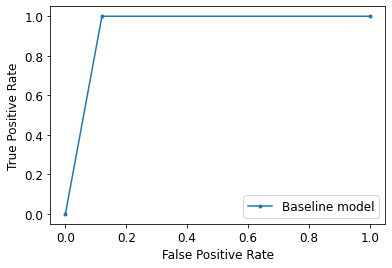

In [12]:
lr_auc = roc_auc_score(y_true, y_pred)
print('ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Baseline model')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [13]:
pr_auc = average_precision_score(y_true, y_pred)
print("PR AUC:", specificity)

PR AUC: 0.88
